## Imports

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVR

import pandas as pd
import numpy as np

from datetime import datetime
import time

import backtrader as bt

## Data laoding from CSV
### Stockdata
* Load data from CSV

In [2]:
stock_list = pd.read_csv('clean_data.csv',sep=',')
u_symbol = stock_list['symbol'].unique()
date = pd.Series(stock_list['datetime'])
stock_list.drop(['datetime'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))
stock_data = {}

for symbol in u_symbol:
    stock_data[symbol] = stock_list[stock_list['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


<Axes: xlabel='log_returns', ylabel='date'>

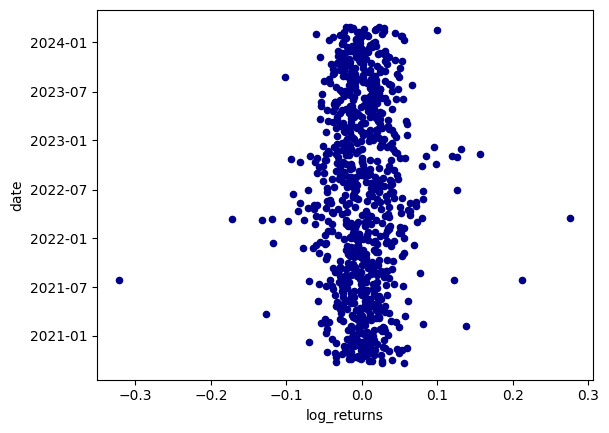

In [3]:
# visualize one stock
stock_data[list(stock_data.keys())[0]].plot.scatter(x='log_returns',y='date',c='DarkBlue')

### Short-selling-reports

In [4]:
short_list = pd.read_excel('stocks_with_listings.xlsx')

## Label Rows
* read time shifted `adj_close` into `signal` such that it can be compared to current date in one row without reverse lookupQQ
* compare previous day and set 1 if stock has risen

In [5]:
# label function
def label_row(row):
    if (row['signal'] - row['log_returns']) > 0:
        return 1
    else:
        return 0
def label_df(df):
    df['signal'] = df['log_returns'].shift(1)
    df.fillna(0)
    df['signal'] = df.apply(label_row,axis=1)
    return df

In [6]:
length = 0
amount_0 = 0
amount_1 = 0 
for ticker in stock_data:
#     stock_data[ticker]['singal'] = stock_data[ticker]['log_returns'].shift(1)
    stock_data[ticker] = label_df(stock_data[ticker])
#     signal = np.array(stock_data[ticker]['signal'])
    amount_0 = amount_0 + len(np.where(stock_data[ticker]['signal'] == 0)[0])
    amount_1 = amount_1 + len(np.where(stock_data[ticker]['signal'] == 1)[0])
print("Total amount of 0's:{0}\nTotal amount of 1's:{1}".format(amount_0,amount_1))


C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['log_returns'].shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df.apply(label_row,axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Total amount of 0's:521145
Total amount of 1's:487322


C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['log_returns'].shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df.apply(label_row,axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17404\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

## Create Bands

In [7]:
# for i in stock_data:
#     df = stock_data[i]
#     if(df['signal'].shape[0] < 10):
#         print(i)
#         print(df['signal'].shape)

## Filter training data

In [8]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [9]:
stocks_after_report = {}

for index, row in short_list.iterrows():
    symbol = row['SYMBOL']
    date_report = row['Date']
    if symbol in list(stock_data.keys()):
        stock_df = stock_data[symbol]
        stock_start_date = nearest(np.array(stock_df['date']),date_report)
        condition = stock_df['date'] == stock_start_date
        start_index = stock_df.index[condition][0]
        # gets all entries of the stock after the shortselling repport for this stock has been rleases
        if(start_index > stock_df.index[-1]):
            print("start index df: {}, end index df: {}, date after report: {}".format(stock_df.index[0],stock_df.index[-1],start_index))
        result = stock_df.loc[start_index:].copy()
        # replace date with column that indicates how many days past release have passed
        incremental = np.arange(0,len(result.date))
        result['index'] = incremental
        # save each dataset
        stocks_after_report[symbol] = result


## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [10]:
# Make sure all dates are in datetime format
short_list['Date'] = short_list['Date'].apply(lambda x: np.datetime64(x)) 
# Sort list by date ascending
short_list.sort_values(by=['Date'], inplace=True, ascending=True)
# Remove entries that arent in the dataset with 
short_list = short_list[short_list['SYMBOL'].isin(stocks_after_report)]
# Get amount of entries
sl_size = short_list.shape[0]
# Get index up to which 70% of the entries are.
position_training_block = int(sl_size*0.7)
# Create Testsplit
train_list = short_list.iloc[:position_training_block]
test_list = short_list.iloc[position_training_block:]

X_train = []
Y_train = []

X_test = []
Y_test = []

for ticker in train_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    y = np.array(stocks_after_report[ticker][['signal']].shift(1).fillna(0))
    #TODO because of the shift right our first element of y is now nan we delete the first day for both. 
    # X_train.append(np.delete(x,0))
    # Y_train.append(np.delete(y,0))
    X_train.append(x) #shape (n,2)
    Y_train.append(y) #shape (n,1)



for ticker in test_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    y = np.array(stocks_after_report[ticker][['signal']])
    X_test.append(x)
    # after shift for some reason values are float
    Y_test.append(y.astype(np.float64))

## Train SVR

In [11]:
regressor = SVR(kernel = 'rbf')
for x_train, y_train in zip(X_train, Y_train):
    # ravel() returns a continious flatened array 
    regressor.fit(x_train,y_train, sample_weight=None)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataC

In [19]:
# Y_pred = {}
amount_0_pred = 0
amount_1_pred = 0
amount_0 = 0
amount_1 = 0
def binary_convertor(value):
    if value >= 0.5:
        return 1
    else:
        return 0
for x_test, y_test in zip(X_test, Y_test):
    y_pred = regressor.predict(x_test)
    y_pred_binary = list(map(binary_convertor,y_pred))
    amount_0 = amount_0 + len(np.where(y_test == 0)[0])
    amount_1 = amount_1 + len(np.where(y_test == 1)[0])
    amount_0_pred = amount_0 + len(np.where(np.array(y_pred_binary) == 0)[0])
    amount_1_pred = amount_1 + len(np.where(np.array(y_pred_binary) == 1)[0])
    # print(y_pred_binary)
    # if(y_pred.max() > a ):
    #     a = y_pred.max()
    # if(y_pred.min() < b ):      
    # #     b = y_pred.max()
    # print("Accuracy:",metrics.accuracy_score(y_test,y_pred_binary))
    # print("Precision:",metrics.precision_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
    # print("Recall:",metrics.recall_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
print("Total amount of 0's:{0}\nTotal amount of 1's:{1}".format(amount_0,amount_1))
print("Total amount of predicted 0's:{0}\nTotal amount of predicted 1's:{1}".format(amount_0_pred,amount_1_pred))

[0.09981505 0.09983439 0.09985984 0.09989129 0.09992874 0.09997214
 0.10002142 0.1000766  0.10013753 0.10020449 0.10027698 0.10035514
 0.10043902 0.10052847 0.10062355 0.10072391 0.10083001 0.10094123
 0.10105782 0.1011797  0.1013068  0.10143908 0.10157635 0.1017186
 0.10186583 0.102018   0.10217495 0.10233694 0.10250317 0.10267434
 0.10285013 0.10302968 0.10321387 0.10340263 0.10359569 0.10379245
 0.10399419 0.10419852 0.10440847 0.10462082 0.10483755 0.10505768
 0.10528142 0.1055091  0.10573942 0.10597342 0.10621118 0.10645091
 0.10669385 0.10694012 0.10718953 0.1074418  0.10769641 0.1079542
 0.1082137  0.10847526 0.10873886 0.10900674 0.10927435 0.10954528
 0.10981788 0.11009266 0.11036883 0.11064458 0.11092474 0.11120447
 0.11148734 0.11177063 0.11205418 0.11233869 0.11262454 0.1129117
 0.11319928 0.11348697 0.11377504 0.11406409 0.11435315 0.11464236
 0.11493264 0.11522077 0.11550947 0.11579895 0.11608704 0.11637631
 0.11666463 0.11695086 0.11723613 0.11752195 0.11780602 0.1180892

## Backtesting with backtradern

### Test Strategy

In [13]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.log_returns = self.datas[0].log_returns
        self.index = self.datas[0].index
        
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        size = self.log_returns.__len__()
    
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        log_return_history = self.log_returns.get(ago=0,size=size)
        index_history = self.index.get(ago=0,size=size)
        series = []
        for index, log in zip(index_history, log_return_history):
            series.append([index,log])
        forecast = regressor.predict(series)
        print(forecast)
        
        # # Check if we are in the market
        # if not self.position:
        #     #TODO recomender goes here
        #     log_return_history = self.log_returns.get(ago=0,size=size)
        #     index_history = self.index.get(ago=0,size=size)
        #     series = []
        #     for index, log in zip(index_history, log_return_history):
        #         series.append([index,log])
        #     forecast = regressor.predict(series)
        #     print(forecast)
        #     # previous close less than the previous close
        #     # BUY, BUY, BUY!!! (with default parameters)
        #     self.log('BUY CREATE, %.2f' % self.dataclose[0])
            
        #     # Keep track of the created order to avoid a 2nd order
        #     self.order = self.buy()

        # else:

        #     # Already in the market ... we might sell
        #     if len(self) >= (self.bar_executed + 5):
        #         # SELL, SELL, SELL!!! (with all possible default parameters)
        #         self.log('SELL CREATE, %.2f' % self.dataclose[0])

        #         # Keep track of the created order to avoid a 2nd order
        #         self.order = self.sell()

### Custom Data feed
We make a custom data feed to inculde the log_returns in our data. We need this to predict. 

In [14]:
class CustomFeed(bt.feeds.PandasData):
    lines = ('datetime', 'open', 'high', 'low',
             'close', 'volume', 'log_returns', 'index')
    params = (
        ('datetime', 'date'),
        ('openinterest',None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('log_returns', -1),
        ('index', -1)
    )

In [15]:
def exec(strategy, df):
    cerebro = bt.Cerebro()
    # Add a strategy
    cerebro.addstrategy(strategy)    
    data = CustomFeed(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    plot = cerebro.plot()
    for index, figure in enumerate(plot[0]):
        # return figure
        figure.savefig("figure_{}.png".format(index)) 

# ---------------------------------
test_list
exec(TestStrategy, stocks_after_report['SLI'])
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# exec(TestStrategy, stock_data['ABAT'])


Starting Portfolio Value: 100000.00
2021-11-18, Close, 8.01
[0.09981514]
2021-11-19, Close, 9.28
[0.09981514 0.09983434]
2021-11-22, Close, 8.43
[0.09981514 0.09983434 0.09985985]
2021-11-23, Close, 8.70
[0.09981514 0.09983434 0.09985985 0.09989129]
2021-11-24, Close, 10.63
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876]
2021-11-26, Close, 9.94
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211]
2021-11-29, Close, 10.89
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211
 0.10002149]
2021-11-30, Close, 10.43
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211
 0.10002149 0.1000766 ]
2021-12-01, Close, 10.42
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211
 0.10002149 0.1000766  0.10013764]
2021-12-02, Close, 10.08
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211
 0.10002149 0.1000766  0.10013764 0.1002044 ]
2021-12-03, Close, 9.42
[0.09981514 0.09983434 0.09985985 0.09989129 0.09992876 0.09997211

<IPython.core.display.Javascript object>

In [16]:
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# print(type(stock_data['ABAT']['date'].iloc[0].to_pydatetime()))
# stock_data.set_index('date', inplace=True)
# print(test_list)
# exec(TestStrategy, stock_data['SLI'])
# print(stock_data['ABAT'].head)
# print(X_test[0])
stocks_after_report['SLI']

,open,high,low,close,volume,symbol,log_returns,date,signal,index
825228,9.25,9.50,6.75,8.01,18834100.0,SLI,-0.208809,2021-11-18,1,0
825229,8.60,9.30,8.20,9.28,4827500.0,SLI,0.147171,2021-11-19,0,1
825230,9.68,9.68,7.87,8.43,4884700.0,SLI,-0.096065,2021-11-22,1,2
825231,8.40,9.09,8.27,8.70,2973900.0,SLI,0.031526,2021-11-23,0,3
825232,9.68,10.74,9.18,10.63,8061600.0,SLI,0.200357,2021-11-24,0,4
...,...,...,...,...,...,...,...,...,...,...
825794,1.22,1.23,1.14,1.19,1250300.0,SLI,-0.016667,2024-02-22,1,566
825795,1.22,1.22,1.12,1.20,1063900.0,SLI,0.008368,2024-02-23,0,567
825796,1.21,1.21,1.12,1.14,1596000.0,SLI,-0.051293,2024-02-26,1,568
825797,1.18,1.25,1.13,1.25,1914900.0,SLI,0.092115,2024-02-27,0,569


In [17]:
# max_abs_scaler = preprocessing.MaxAbsScaler()
# a = []
# model_dict = {}
# for index, row in short_list.iterrows():
#     if row['SYMBOL'] in list(stocks_after_report.keys()):
#         report_release_date =  row['Date']
#         #todo replace occurances of i with symbol
#         i = symbol
#         # read df into np.array
#         X = np.array(stocks_after_report[i].drop(['signal','date'],axis=1))
#         X = max_abs_scaler.fit_transform(X)
#         Y = np.array(stocks_after_report[i]['signal'])

#         # split
#         X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


#         model_dict[i] = {}
#         model_dict[i]['X Train'] = X_train
#         model_dict[i]['X Test'] = X_test
#         model_dict[i]['Y Train'] = y_train
#         model_dict[i]['Y Test'] = y_test
        
#         model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='linear')
#         # model = svm.SVC(kernel='linear',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='poly')
#         # model = svm.SVC(kernel='poly',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='sigmoid')
#         # model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

#         # fit and test
#         try:
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             model_dict[i]['Y Prediction'] = y_pred
#             print("SVM Model Info for Ticker: "+i)
#             print("Accuracy:",metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction']))
#             model_dict[i]['Accuracy'] = metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'])
#             print("Precision:",metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Precision'] = metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             print("Recall:",metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Recall'] = metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             #print("#################### \n")
#         except: 
#             a.append(i)


In [18]:
# for i in stock_data:
#     #todo is this rly smart
#     stock_data[i]['Returns'] = np.log(stock_data[i]['adj_close']/stock_data[i]['adj_close'].shift(1)) 

#     prediction_length = len(model_dict[i]['Y Prediction'])

#     stock_data[i]['SVM Signal'] = 0
#     stock_data[i]['SVM Returns'] = 0
#     stock_data[i]['Total Strat Returns'] = 0
#     stock_data[i]['Market Returns'] = 0

#     Signal_Column = stock_data[i].columns.get_loc('SVM Signal')
#     Strat_Column = stock_data[i].columns.get_loc('SVM Returns')
#     Return_Column = stock_data[i].columns.get_loc('Total Strat Returns')
#     Market_Column = stock_data[i].columns.get_loc('Market Returns')
        
#     stock_data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,model_dict[i]['Y Prediction']))
#     stock_data[i]['SVM Returns'] = stock_data[i]['SVM Signal'] * stock_data[i]['Returns'].shift(1)

#     stock_data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(stock_data[i]['SVM Returns'][-prediction_length:])
#     stock_data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(stock_data[i]['Returns'][-prediction_length:])
#     # print(stock_data[i]['Total Strat Returns'].head)

#     # model_dict[i]['Sharpe_Ratio'] = (stock_data[i]['Total Strat Returns'][-1] - stock_data[i]['Market Returns'][-1])/ \
#     #                 np.nanstd(stock_data[i]['Total Strat Returns'][-prediction_length:])